In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

# API Banco Central do Brasil SGS
https://dadosabertos.bcb.gov.br/dataset/20542-saldo-da-carteira-de-credito-com-recursos-livres---total/resource/6e2b0c97-afab-4790-b8aa-b9542923cf88?inner_span=True

In [22]:
class sgs():
    def __init__(self):
        self.base_url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.'
        
    def get_series(self,series_number,init_date = None,end_date = None,last = None):
        # Convert series number into string
        series_number = str(series_number)
        # Create full_url based on inputs
        self.create_url(series_number,init_date = None,end_date = None,last = None)
        # Request full_url in sgs API
        self.response = requests.get(self.full_url)
        # Format series
        self.pandify_series()
        
        return self.series
    
    def create_url(self,series_number,init_date = None,end_date = None,last = None):
        # Check if there is a date filter
        if (init_date is not None) and (end_date is not None):
            self.param_url = f'{series_number}/formato=json&dataInicial={init_date}&dataFinal={end_date}'
        # Check if there is a n_last filter
        elif (last is not None):
            self.param_url = f'{series_number}/formato=json&dataInicial={init_date}&dataFinal={end_date}'
        # If no filters found, get the whole series
        else:
            self.param_url = series_number+'/dados?formato=json'
            
        # Create full_url based on base_url and param_url
        self.full_url = self.base_url + self.param_url
        
        return self.base_url + self.param_url
    
    def pandify_series(self):
        # Create pandas dataframe from response
        series = pd.DataFrame(self.response.json())
        # Fromat date and set it as index
        series['data'] = pd.to_datetime(series['data'],format='%d/%m/%Y')
        series = series.set_index('data')
        # Guarantee series value is float
        series['valor'] = series['valor'].astype(float)
        
        self.series = series
        return series

In [23]:
SGS = sgs()

In [24]:
# Importa as tabelas baseado em seu número no SGS (Olhar no site)
selic = SGS.get_series('1178')
meta_selic = SGS.get_series('432')

IPCA = SGS.get_series('13522')
meta_inflacao = SGS.get_series('13521')

IGP_M = SGS.get_series('189')

delta_selic = meta_selic['valor']-selic['valor']

## Cartas abertas inflação
https://www.bcb.gov.br/pec/cartaaberta.asp?frame=1

In [25]:
carta_years = ['2002-01-01','2003-01-01','2004-01-01','2016-01-01','2018-01-01']

In [26]:
# https://www.bcb.gov.br/controleinflacao/historicometas
banda_meta_inflacao = pd.DataFrame()
banda_meta_inflacao['data'] = meta_inflacao.index
banda_meta_inflacao['valor'] = None

banda_meta_inflacao.loc[banda_meta_inflacao['data']<='2002','valor'] = 2
banda_meta_inflacao.loc[(banda_meta_inflacao['data']>='2003')&(banda_meta_inflacao['data']<='2005'),'valor'] = 2.5
banda_meta_inflacao.loc[(banda_meta_inflacao['data']>='2006')&(banda_meta_inflacao['data']<='2016'),'valor'] = 2
banda_meta_inflacao.loc[banda_meta_inflacao['data']>='2017','valor'] = 1.5

banda_meta_inflacao = banda_meta_inflacao.set_index('data')
banda_meta_inflacao

,valor
data,
1999-01-01,2
2000-01-01,2
2001-01-01,2
2002-01-01,2
2003-01-01,2.5
2004-01-01,2.5
2005-01-01,2.5
2006-01-01,2
2007-01-01,2


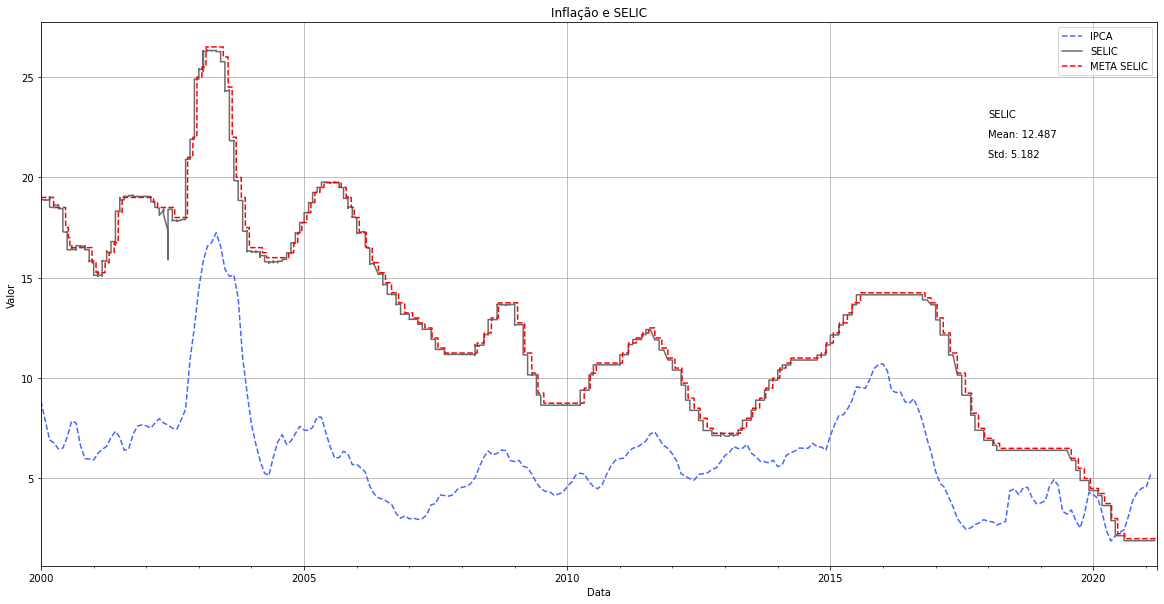

In [49]:
IPCA['valor'].loc['2000':].plot(color='#4766ff',linestyle='--',figsize = (20,10))
selic['valor'].loc['2000':].plot(figsize = (20,10),color='#6b6b6b')
meta_selic['valor'].loc['2000':].plot(color='red',linestyle='--')

plt.legend(['IPCA','SELIC','META SELIC'])

media_selic = round(selic['valor'].loc['2000':].mean(),3)
std_selic = round(selic['valor'].loc['2000':].std(),3)

y = 21
x = '2018'
plt.text(x,y+2, f'SELIC')
plt.text(x,y+1, f'Mean: {media_selic}')
plt.text(x,y, f'Std: {std_selic}')

plt.grid(True)
plt.title('Inflação e SELIC')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.show()

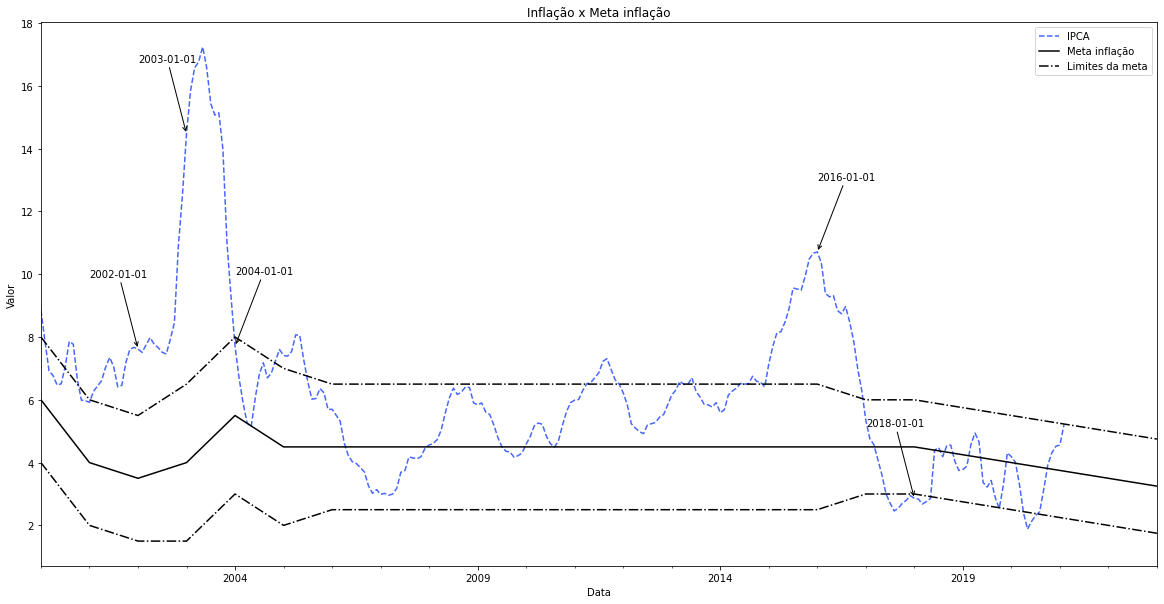

In [28]:
IPCA['valor'].loc['2000':].plot(color='#4766ff',linestyle='--',figsize = (20,10))
meta_inflacao['valor'].loc['2000':].plot(color='black')
(meta_inflacao['valor']+banda_meta_inflacao['valor']).loc['2000':].plot(color='black',linestyle='-.')
(meta_inflacao['valor']-banda_meta_inflacao['valor']).loc['2000':].plot(color='black',linestyle='-.')
#selic['valor'].loc['2000':].plot(figsize = (15,10),color='#f74d63',secondary_y=True)
#meta_selic['valor'].loc['2000':].plot(color='black')

for year in carta_years:
    year_text = year
    if year == '2002-01-01':
        year_text = '2001-01-01'
        
    if year == '2003-01-01':
        year_text = '2002-01-01'
    
    if year == '2018-01-01':
        year_text = '2017-01-01'
    
    plt.annotate(year,(year,IPCA['valor'].loc[year]),
                 xytext=(year_text,IPCA['valor'].loc[year]+2.3),
                arrowprops=dict(arrowstyle ='->' ,facecolor='black'))
plt.legend(['IPCA','Meta inflação','Limites da meta'])
#plt.grid(True)
plt.title('Inflação x Meta inflação')
plt.ylabel('Valor')
plt.xlabel('Data')
plt.show()